In [4]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import sklearn.preprocessing as skl

In [5]:
def read_file(file_name, spliter=' '):
    f = open(file_name)
    line = f.readline()
    data = []  # 二维数组，[样本总数，720数据]

    while line:
        trainRead = line.split(spliter)
        for i in range(len(trainRead)):
            trainRead[i] = float(trainRead[i])
        data.append(trainRead)
        line = f.readline()
    return data

In [6]:
# AE Model
num_hidden_1 = 256  # 1st layer num features
num_hidden_2 = 128  # 2nd layer num features (the latent dim)
num_hidden_3 = 128
num_input = 720  # img shape: 60*12

AE_steps = 30000
display_step = AE_steps / 10

# combine data
sampleDataSet = []  # [7,32,720]
sampleDataSet.append(read_file("data/imgs_sample_1.txt"))
sampleDataSet.append(read_file("data/imgs_sample_2.txt"))
sampleDataSet.append(read_file("data/imgs_sample_3.txt"))
sampleDataSet.append(read_file("data/imgs_sample_4.txt"))
sampleDataSet.append(read_file("data/imgs_sample_5.txt"))
sampleDataSet.append(read_file("data/imgs_sample_6.txt"))
sampleDataSet.append(read_file("data/imgs_sample_7.txt"))

# FingerPrint
FPDataSet = read_file("data/ECFPs.txt", '  ')  # [32,128]

# normalize
for i in range(len(sampleDataSet)):
    sampleDataSet[i] = skl.normalize(sampleDataSet[i], axis=1)
# print(sampleDataSet[0][0])

In [7]:

# Delete sample only include zero
trainAE = []  # data for training
for i in range(len(sampleDataSet)):
    for j in range(len(sampleDataSet[i])):
        if np.sum(sampleDataSet[i][j] != 0):
            trainAE.append(sampleDataSet[i][j])  # shape [7, 32, 720] --> [212, 720]
# print("trainDataSetAE: ", len(trainDataSetAE))  # 212


# training of regression
trainNN = []
for i in range(32):  #
    tmpArray = []
    for j in range(7):  #
        if np.sum(sampleDataSet[j][i] != 0):
            tmpArray.append(sampleDataSet[j][i])
        trainNN.append(tmpArray)
print("trainDataSetReg: ", len(trainNN))  # 224, 7, 720


trainDataSetReg:  224


In [8]:
# AutoEncoder model
img_input = tf.placeholder('float32', [None, num_input])

weights = {
    'encoder_h1': tf.Variable(tf.random_normal([num_input, num_hidden_1])),
    'encoder_h2': tf.Variable(tf.random_normal([num_hidden_1, num_hidden_2])),
    # 'encoder_h3': tf.Variable(tf.random_normal([num_hidden_2, num_hidden_3])),
    'decoder_h1': tf.Variable(tf.random_normal([num_hidden_2, num_hidden_1])),
    'decoder_h2': tf.Variable(tf.random_normal([num_hidden_1, num_input])),
    # 'decoder_h3': tf.Variable(tf.random_normal([num_hidden_1, num_input])),
}
biases = {
    'encoder_b1': tf.Variable(tf.random_normal([num_hidden_1])),
    'encoder_b2': tf.Variable(tf.random_normal([num_hidden_2])),
    # 'encoder_b3': tf.Variable(tf.random_normal([num_hidden_3])),
    'decoder_b1': tf.Variable(tf.random_normal([num_hidden_1])),
    'decoder_b2': tf.Variable(tf.random_normal([num_input])),
    # 'decoder_b3': tf.Variable(tf.random_normal([num_input])),
}


def encoder(x):
    layer_1 = tf.nn.sigmoid(tf.add(tf.matmul(x, weights['encoder_h1']), biases['encoder_b1']))
    layer_2 = tf.nn.sigmoid(tf.add(tf.matmul(layer_1, weights['encoder_h2']), biases['encoder_b2']))
    # layer_3 = tf.nn.sigmoid(tf.add(tf.matmul(layer_2, weights['encoder_h3']), biases['encoder_b3']))
    return layer_2


def decoder(x):
    layer_1 = tf.nn.sigmoid(tf.add(tf.matmul(x, weights['decoder_h1']), biases['decoder_b1']))
    layer_2 = tf.nn.sigmoid(tf.add(tf.matmul(layer_1, weights['decoder_h2']), biases['decoder_b2']))
    # layer_3 = tf.nn.sigmoid(tf.add(tf.matmul(layer_2, weights['decoder_h3']), biases['decoder_b3']))
    return layer_2


In [9]:
# model
encoder_op = encoder(img_input)
decoder_op = decoder(encoder_op)

y_pred = decoder_op  # reconstructed image
y_true = img_input  # original image

learning_rate = 0.01
learning_rate2 = learning_rate / 10
learning_rate3 = learning_rate2 / 10

loss = tf.reduce_mean(tf.pow(y_true - y_pred, 2))
optimizer = tf.train.RMSPropOptimizer(learning_rate).minimize(loss)
optimizer2 = tf.train.AdamOptimizer(learning_rate2).minimize(loss)
optimizer3 = tf.train.AdamOptimizer(learning_rate3).minimize(loss)

sess = tf.Session()
sess.run(tf.global_variables_initializer())

# Training
batch_x = trainAE  # 212
# print("batch_x: ", len(batch_x))

_, l = sess.run([optimizer, loss], feed_dict={img_input: batch_x})
for j in range(AE_steps):
    if j <= AE_steps * 1 / 3:
        _, l = sess.run([optimizer, loss], feed_dict={img_input: batch_x})
    elif j <= AE_steps * 2 / 3:
        _, l = sess.run([optimizer2, loss], feed_dict={img_input: batch_x})
    else:
        _, l = sess.run([optimizer3, loss], feed_dict={img_input: batch_x})
    if j % display_step == 0:
        print('Step {0}: Minibatch Loss: {1:<6f}'.format(j, l))


Step 0: Minibatch Loss: 0.478109
Step 3000: Minibatch Loss: 0.092538
Step 6000: Minibatch Loss: 0.087212
Step 9000: Minibatch Loss: 0.080446
Step 12000: Minibatch Loss: 0.026687
Step 15000: Minibatch Loss: 0.026586
Step 18000: Minibatch Loss: 0.023993
Step 21000: Minibatch Loss: 0.023988
Step 24000: Minibatch Loss: 0.023987
Step 27000: Minibatch Loss: 0.023986


Original Images


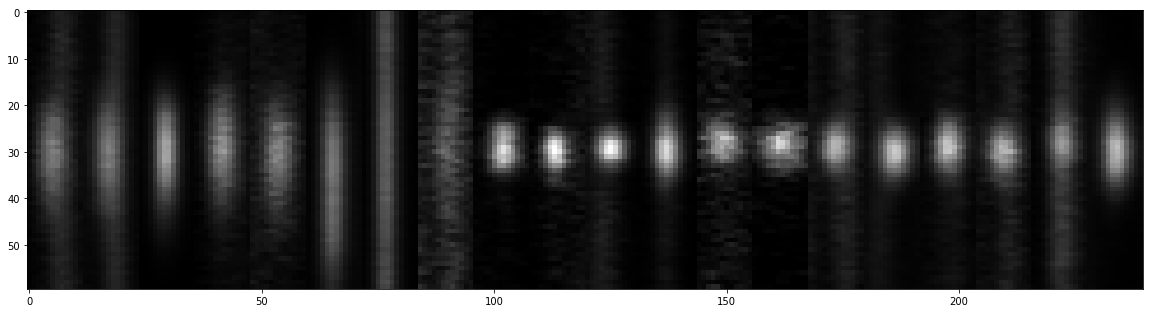

Reconstructed Images


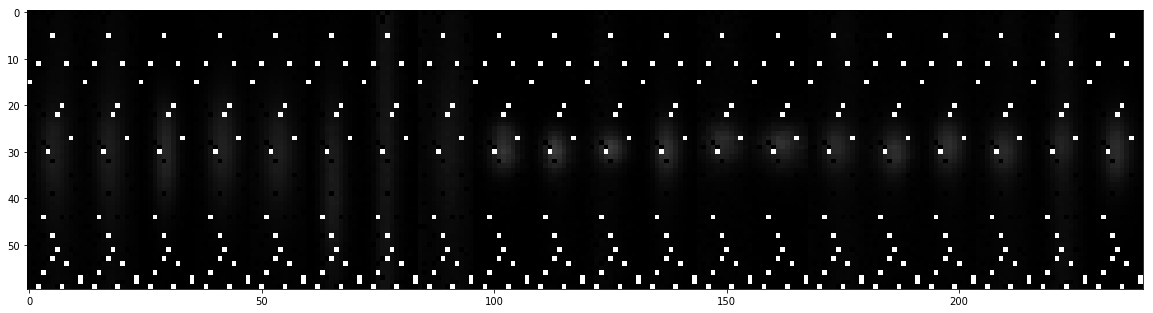

In [11]:
# test performance of AE
n = 1
m = 20
canvas_orig = np.empty((60, 12 * m))
canvas_recon = np.empty((60, 12 * m))
for i in range(n):
    batch_x = trainAE
    # Encode and decode the digit image
    g = sess.run(decoder_op, feed_dict={img_input: batch_x})

    # Display original images
    for j in range(m):
        # Draw the original digits
        # canvas_orig[i * 60:(i + 1) * 60, j * 12:(j + 1) * 12] = batch_x[j].reshape([60, 12])
        canvas_orig[0:60, j * 12:(j + 1) * 12] = batch_x[j + 24].reshape([60, 12])
    # Display reconstructed images
    for j in range(m):
        # Draw the reconstructed digits
        # canvas_recon[i * 60:(i + 1) * 60, j * 12:(j + 1) * 12] = g[j].reshape([60, 12])
        canvas_recon[0:60, j * 12:(j + 1) * 12] = g[j + 24].reshape([60, 12])

print("Original Images")
plt.figure(figsize=(m, m))
plt.imshow(canvas_orig, origin="upper", cmap="gray")
plt.show()

print("Reconstructed Images")
plt.figure(figsize=(m, m))
plt.imshow(canvas_recon, origin="upper", cmap="gray")
plt.show()


In [12]:
# Classification

result_y = []
for i in range(len(trainNN)):
    batch_x = trainNN[i]  # [7,720]
    batch_y = sess.run(encoder_op, feed_dict={img_input: batch_x})  # [7,128]
    result_y.append(batch_y)


def random_choose(x):
    randInt = np.random.randint(low=0, high=32)
    while x == randInt:
        randInt = np.random.randint(low=0, high=32)
    return randInt


# neg / pos set
negative_ratio = 3
batch_data = []  # [None, 256]
batch_label = []  # [None, 2]
for i in range(len(trainNN)):
    data_x = trainNN[i]  # [7,720]
    data_y = sess.run(encoder_op, feed_dict={img_input: data_x})  # [7,128]

    data_fpT = []  # [7,128]
    data_fpF = []  # [3,7,128]

    for j in range(len(data_y)):
        data_fpT.append(FPDataSet[j])

    for j in range(negative_ratio):
        tmp = []
        for k in range(len(data_y)):
            tmp.append(FPDataSet[random_choose(i)])
        data_fpF.append(tmp)

    # Combine new data
    sample_T = np.append(data_y, data_fpT, axis=1)  # [7,256]
    sample_F = np.append(data_y, data_fpF[0], axis=1)  # [21,256]
    for j in range(1, negative_ratio):
        sample_F = np.append(sample_F, np.append(data_y, data_fpF[j], axis=1), axis=0)

    if batch_data == []:
        batch_data = np.append(sample_T, sample_F, axis=0)
    else:
        batch_data = np.append(batch_data, sample_T, axis=0)
        batch_data = np.append(batch_data, sample_F, axis=0)
    for j in range(len(sample_T)):
        batch_label.append([0, 1])  # T
    for j in range(len(sample_F)):
        batch_label.append([1, 0])  # F


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:43: DeprecationWarning: elementwise == comparison failed; this will raise an error in the future.


In [15]:
# training model
data_size = 256
l1_size = 64
l2_size = 32
l3_size = 8
out_size = 2

# 占位符，基本训练变量
data_input = tf.placeholder(tf.float32, [None, data_size])
label_input = tf.placeholder(tf.int64, [None, 2])

weightsNN = {
    'layer_w1': tf.Variable(tf.random_normal([data_size, l1_size])),
    'layer_w2': tf.Variable(tf.random_normal([l1_size, l2_size])),
    'layer_w3': tf.Variable(tf.random_normal([l2_size, l3_size])),
    'layer_wo': tf.Variable(tf.random_normal([l3_size, out_size])),
}

biasesNN = {
    'layer_b1': tf.Variable(tf.random_normal([l1_size])),
    'layer_b2': tf.Variable(tf.random_normal([l2_size])),
    'layer_b3': tf.Variable(tf.random_normal([l3_size])),
    'layer_bo': tf.Variable(tf.random_normal([out_size])),
}


def network(x):  
    layer_1 = tf.add(tf.matmul(x, weightsNN['layer_w1']), biasesNN['layer_b1'])
    layer_2 = tf.add(tf.matmul(layer_1, weightsNN['layer_w2']), biasesNN['layer_b2'])
    layer_3 = tf.add(tf.matmul(layer_2, weightsNN['layer_w3']), biasesNN['layer_b3'])
    layer_o = tf.add(tf.matmul(layer_3, weightsNN['layer_wo']), biasesNN['layer_bo'])
    return layer_o


y_conv = network(data_input)
cross_entropy = tf.nn.softmax_cross_entropy_with_logits(labels=label_input, logits=y_conv)
optimizerNN = tf.train.AdamOptimizer(1e-5).minimize(cross_entropy)
correct_prediction = tf.equal(tf.argmax(label_input, 1), tf.argmax(y_conv, 1))
test_out = tf.argmax(y_conv, 1)
accuracy = tf.reduce_mean(tf.cast(correct_prediction, "float"))

sessNN = tf.Session()
sessNN.run(tf.global_variables_initializer())

# training
train_step = 10000
print_step = train_step / 20
for i in range(train_step):
    sessNN.run(optimizerNN, feed_dict={data_input: batch_data, label_input: batch_label})
    if i % print_step == 0:
        acc = sessNN.run(accuracy, feed_dict={data_input: batch_data, label_input: batch_label})
        print("step:", i, "training accuracy:", acc)
#         print("test_out: ", test_out)

acc = sessNN.run(accuracy, feed_dict={data_input: batch_data, label_input: batch_label})
print("Final accuracy:", acc)


step: 0 training accuracy: 0.638477
step: 500 training accuracy: 0.604953
step: 1000 training accuracy: 0.603437
step: 1500 training accuracy: 0.599899
step: 2000 training accuracy: 0.608659
step: 2500 training accuracy: 0.620957
step: 3000 training accuracy: 0.624832
step: 3500 training accuracy: 0.627358
step: 4000 training accuracy: 0.652291
step: 4500 training accuracy: 0.662736
step: 5000 training accuracy: 0.697608
step: 5500 training accuracy: 0.72473
step: 6000 training accuracy: 0.75438
step: 6500 training accuracy: 0.75876
step: 7000 training accuracy: 0.758929
step: 7500 training accuracy: 0.761961
step: 8000 training accuracy: 0.762298
step: 8500 training accuracy: 0.797001
step: 9000 training accuracy: 0.802224
step: 9500 training accuracy: 0.808625
Final accuracy: 0.807783
